In this notebook we perform further modelling of the data with a LightGBM model.

# Modelling

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder

pd.options.display.max_rows = None

In [2]:
ts = time.time()
data = pd.read_pickle('data.pkl')
time.time() - ts

6.083390474319458

In [3]:
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')

X = data.drop('item_cnt_month_shop_item', axis = 1) # We drop the target.

X_train = X[X.date_block_num < 33]
y_train = data[data.date_block_num < 33]['item_cnt_month_shop_item']

X_val = X[X.date_block_num == 33]
y_val = data[data.date_block_num == 33]['item_cnt_month_shop_item']

X_test = X[X.date_block_num == 34]
X_test = X_test.reset_index()
del X_test['index']
del data
del X
gc.collect();

print('No. records in training data:', len(X_train))
print('No. records in validation data:', len(X_val))
print('No. records in test data:', len(X_test))

No. records in training data: 9353378
No. records in validation data: 236324
No. records in test data: 214200


We build and train a LightGBM model with optimized hyperparameters.

In [4]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params = params, train_set = lgb_train, valid_sets = (lgb_train, lgb_val), verbose_eval = 50,
                      categorical_feature = cat_features)    
    return model

In [5]:
params = {
    'seed': 1,
    'objective': 'rmse',
    'metric': 'rmse',
    'num_rounds': 10000,    
    'early_stopping_rounds': 50,    
    'num_leaves': 1023,    
    'min_data_in_leaf':10,    
    'feature_fraction':0.7,
    'learning_rate': 0.01     
}

# Designating the categorical features which should be focused on
cat_features = ['item_category_id', 'month', 'shop_id', 'city_code']

In [6]:
ts = time.time()
model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)
time.time() - ts

Found `num_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'item_category_id', 'month', 'shop_id']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 7.075437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28630
[LightGBM] [Info] Number of data points in the train set: 9353378, number of used features: 187


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 0.300169
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.970559	valid_1's rmse: 0.97892
[100]	training's rmse: 0.83901	valid_1's rmse: 0.908601
[150]	training's rmse: 0.769218	valid_1's rmse: 0.878242
[200]	training's rmse: 0.728826	valid_1's rmse: 0.863526
[250]	training's rmse: 0.701677	valid_1's rmse: 0.85609
[300]	training's rmse: 0.681149	valid_1's rmse: 0.851155
[350]	training's rmse: 0.665016	valid_1's rmse: 0.847806
[400]	training's rmse: 0.652145	valid_1's rmse: 0.845744
[450]	training's rmse: 0.64114	valid_1's rmse: 0.843993
[500]	training's rmse: 0.631678	valid_1's rmse: 0.842535
[550]	training's rmse: 0.62368	valid_1's rmse: 0.841586
[600]	training's rmse: 0.616501	valid_1's rmse: 0.840862
[650]	training's rmse: 0.610032	valid_1's rmse: 0.840494
[700]	training's rmse: 0.604109	valid_1's rmse: 0.840132
[750]	training's rmse: 0.598512	valid_1's rmse: 0.839769
[800]	training's rmse: 0.593284	valid

2389.1025488376617

In [7]:
filename = 'lgb_model_best.txt' 

In [8]:
#model.save_model(filename)

In [9]:
model = lgb.Booster(model_file = filename)

In [10]:
y_test = model.predict(X_test).clip(0, 20)

my_submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
my_submission.to_csv('lgb_submission.csv', index=False)
my_submission.head()

,ID,item_cnt_month
0,0,0.683656
1,1,1.414929
2,2,1.054114
3,3,0.955902
4,4,2.214907


<Figure size 432x288 with 0 Axes>

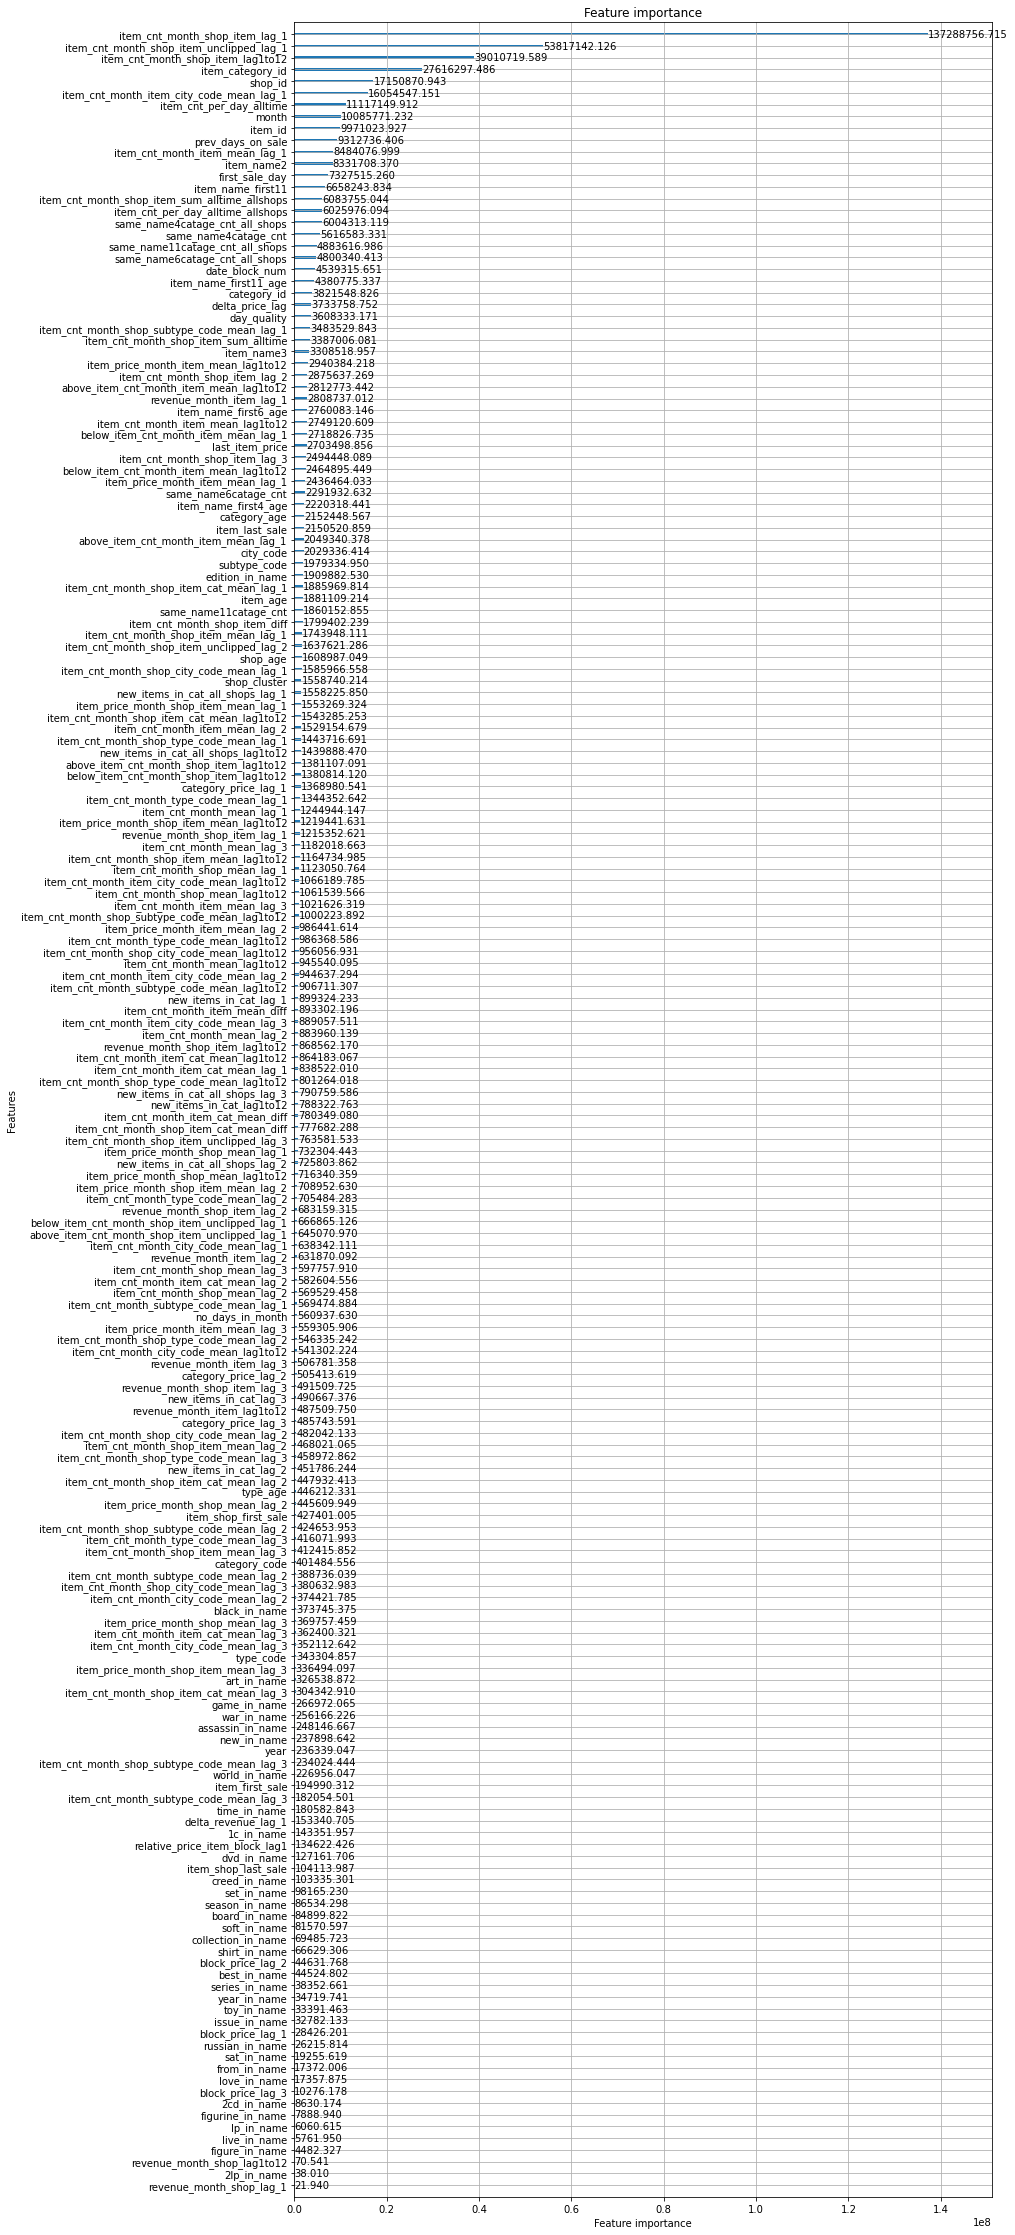

In [11]:
plt.tight_layout()
plot = lgb.plot_importance(model, figsize = (12.5, 40), importance_type = 'gain')
fig = plot.get_figure()

In [12]:
print('Number of total features:', len(model.feature_importance()))
features_to_keep_lgb = []
thresh = 0
for feat_imp, feat_name in zip(model.feature_importance(), model.feature_name()):
    if feat_imp > thresh:
        features_to_keep_lgb.append(feat_name)
print('Number of features with non-zero feature importance:', len(features_to_keep_lgb))
print('Features with zero feature importance:', set(list(X_train.columns)) - set(features_to_keep_lgb))

Number of total features: 187
Number of features with non-zero feature importance: 184
Features with zero feature importance: {'audiobooks_in_name', 'revenue_month_shop_lag_2', 'revenue_month_shop_lag_3'}


# Evaluation of model
Training score: 0.559864, 
validation score: 0.837486,
public LB score: 0.881983,
private LB score: 0.880165	 